[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO-NAS on Custom Dataset

This notebook is based on official [YOLO-NAS Notebook](https://colab.research.google.com/drive/1q0RmeVRzLwRXW-h9dPFSOchwJkThUy6d?usp=sharing) by DECI AI.

![YOLO-NAS on RF100](https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/source/images/yolo_nas_rf100.png)

## ⚠️ Disclaimer

YOLO-NAS is still very fresh. If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLO-NAS
- Inference with pre-trained COCO model
- Finding open source datasets
- ⭐️ Training YOLO-NAS on your custom dataset ⭐️
- Load trained model
- Evaluate trained model
- Inference with trained model

## 🔥 Let's begin!

## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Sep  5 13:28:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install YOLO-NAS


In [2]:
!pip install -q super-gradients==3.2.0
!pip install -q roboflow
!pip install -q supervision

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.1.4 requires pyparsing==2.4.7, but you have pyparsing 2.4.5 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
super-gradients 3.2.0 requires pyparsing==2.4.5, but you have pyparsing 2.4.7 which is incompatible.


In [6]:
!pip install -q pyparsing==2.4.7

### 🚨 Restart the runtime

**After installation is complete, you'll need to restart the runtime after installation completes. Navigate to `Runtime` -> `Restart runtime` and confirm by clicking `Yes` when you see the popup.**

After that, carry on with the notebook starting from the cell below 👇

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Inference with pre-trained COCO model

Start by instantiating a pretrained model. YOLO-NAS architecture comes in three different sizes: `yolo_nas_s`, `yolo_nas_m`, `and yolo_nas_l`. We will use `yolo_nas_l` throughout this notebook. Keep in mind that depending on your use-case your decision may be different. Take a peek at the diagram below visualizing the speed-accuracy tradeoff.

<br>

![YOLO-NAS](https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/source/images/yolo_nas_frontier.png)


In [4]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
MODEL_ARCH = 'yolo_nas_l'

In [5]:
from super_gradients.training import models

model = models.get(MODEL_ARCH, pretrained_weights="coco").to(DEVICE)

[2023-09-05 13:29:29] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-09-05 13:29:31] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-09-05 13:29:38] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-09-05 13:29:39] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-09-05 13:29:39] WARNING - export.py - Failed to import pytorch_quantization
[2023-09-05 13:29:39] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-09-05 13:29:40] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to 

### Use Example Data (Below, We'll Prepare Our Own Custom Dataset)

Let's download few example images. Feel free to replace my images with yours. All you have to do is upload them to the `{HOME}/data` directory. If you're looking for data, take a peek at [Roboflow Universe](https://universe.roboflow.com/)! You're sure to find something interesting.

In [7]:
f"{HOME}/data"

'/content/data'

In [8]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-5.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-6.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-7.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-8.jpeg

/content
/content/data


### Single Image Inference

In [9]:
SOURCE_IMAGE_PATH = f"{HOME}/data/dog-3.jpeg"

In [10]:
import cv2

image = cv2.imread(SOURCE_IMAGE_PATH)
result = list(model.predict(image, conf=0.35))[0]

[2023-09-05 13:30:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


### Output format

For every image YOLO-NAS will produce `ImageDetectionPrediction` object containing the following fields:
- `image` - `numpy.ndarray` - image used for inference
- `class_names` - `List[str]` - list of categories used for training the model
- `prediction` - `DetectionPrediction` - class instance containing detailed informationabout the obtained detections
   - `bboxes_xyxy` - `numpy.ndarray` of `float32` and `(N, 4)` shape - detection bounding boxes in `xyxy` format
   - `confidence` - `numpy.ndarray` of `float32` and `(N,)` shape - confidence value between `0` and `1`
   - `labels` - `numpy.ndarray` of `float32` and `(N,)` shape - `class_id` related to the index in the `class_names` list

In [11]:
type(result)

super_gradients.training.utils.predict.prediction_results.ImageDetectionPrediction

### Visualize Inference Result

As with other models, you can use Supervision to visualize your results. You can read more about the integration between Supervision and YOLO-NAS [here](https://roboflow.github.io/supervision/detection/core/#supervision.detection.core.Detections.from_yolo_nas), and about visualizing detection [here](https://roboflow.github.io/supervision/detection/annotate/#supervision.detection.annotate.BoxAnnotator.annotate).

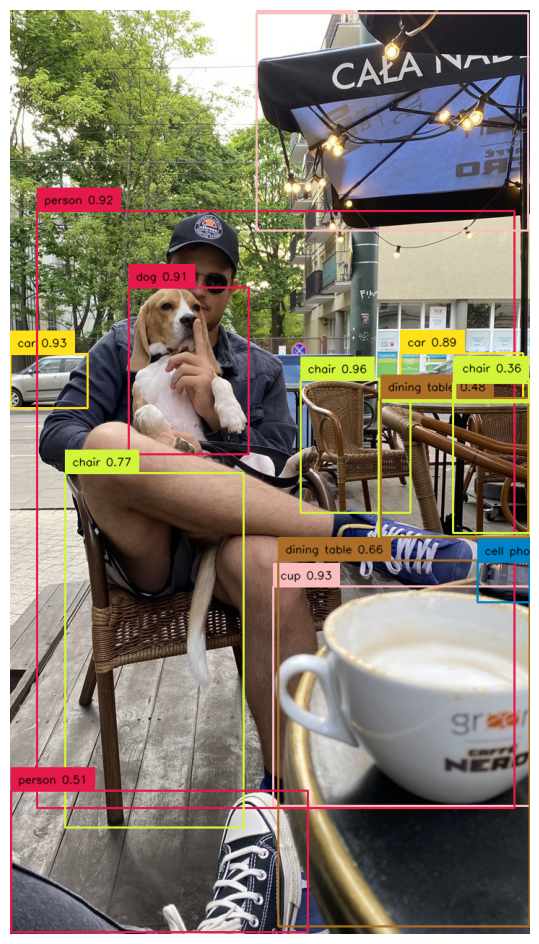

In [12]:
import supervision as sv

detections = sv.Detections(
    xyxy=result.prediction.bboxes_xyxy,
    confidence=result.prediction.confidence,
    class_id=result.prediction.labels.astype(int)
)

box_annotator = sv.BoxAnnotator()

labels = [
    f"{result.class_names[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections
]

annotated_frame = box_annotator.annotate(
    scene=image.copy(),
    detections=detections,
    labels=labels
)

%matplotlib inline
sv.plot_image(annotated_frame, (12, 12))

## Over 100k Open Source Computer Vision Datasets are on Roboflow Universe

Need data for your project? Before spending time on annotating, check out Roboflow Universe, a repository of more than 110,000 open-source datasets that you can use in your projects. You'll find datasets containing everything from annotated cracks in concrete to plant images with disease annotations.


[![Roboflow Universe](https://media.roboflow.com/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)



# Training YOLO-NAS on a Custom Dataset

## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/creating-project.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929799852"
  >
</div>

### Step 2: Uploading images or video

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).

<div align="center">
  <img
    width="640"
    src="https://user-images.githubusercontent.com/26109316/210901980-04861efd-dfc0-4a01-9373-13a36b5e1df4.gif"
  >
</div>

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v5 PyTorch` dataset format.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>




In [15]:
LOCATION = dataset.location
print("location:", LOCATION)
CLASSES = sorted(project.classes.keys())
print("classes:", CLASSES)

location: /content/CCHA_detector-5
classes: ['CC', 'HA']


In [14]:


from roboflow import Roboflow
rf = Roboflow(api_key="KambJHvvNRVwsQ1xhopi")
project = rf.workspace("fafu").project("ccha_detector")
dataset = project.version(5).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to CCHA_detector-5 in yolov5pytorch::  30%|███       | 378/1242 [00:00<00:00, 1855.54it/s]

## Fine-tune on custom dataset

`ckpt_root_dir` - this is the directory where results from all your experiments will be saved

`experiment_name` - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.

In [42]:
MODEL_ARCH = 'yolo_nas_l'
BATCH_SIZE = 16
MAX_EPOCHS = 300
CHECKPOINT_DIR = f'{HOME}/checkpoints'
EXPERIMENT_NAME = project.name.lower().replace(" ", "_")

In [43]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [44]:
dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

In [45]:
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

[2023-09-05 14:47:21] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 431/431 [00:00<00:00, 1645.27it/s]
[2023-09-05 14:47:21] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 123/123 [00:00<00:00, 1555.63it/s]
[2023-09-05 14:47:22] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 61/61 [00:00<00:00, 4912.68it/s]


**NOTE:** Let's inspect our dataset

In [46]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

### Instantiate the model

In [47]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

[2023-09-05 14:47:31] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-09-05 14:47:33] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


### Define metrics and training parameters

In [48]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

### Train the model

In [ ]:
trainer.train(
    model=best_model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

The console stream is now moved to /content/checkpoints/ccha_detector/console_Sep05_14_48_03.txt


[2023-09-05 14:48:04] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-09-05 14:48:10] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 427        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         26         (len(train_loader))
    - Gradient updates per epoch:   26         (len(train_loader) / batch_accumulate)

[2023-09-05 14:48:10] INFO - sg_trainer.py - Started training for 300 epochs (0/299)

Validating: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


### Analyze training metrics


In [ ]:
%load_ext tensorboard
%tensorboard --logdir {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

## Zip and download fine-tuned model

In [29]:
!zip -r yolo_nas.zip {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

NotImplementedError: ignored

In [27]:
 import locale
 locale.getpreferredencoding = lambda: "UTF-8"


'en_US.UTF-8'

In [30]:
import os

# Set the LC_ALL environment variable to a UTF-8 locale
os.environ['LC_ALL'] = 'en_US.UTF-8'

# Run the zip command
!zip -r yolo_nas.zip {CHECKPOINT_DIR}/{EXPERIMENT_NAME}


NotImplementedError: ignored

In [31]:
import shutil

# Define the source directory to zip
source_dir = os.path.join(CHECKPOINT_DIR, EXPERIMENT_NAME)

# Define the ZIP file name
zip_file_name = 'yolo_nas.zip'

# Create a ZIP archive using shutil
shutil.make_archive(zip_file_name.replace('.zip', ''), 'zip', source_dir)

# Rename the generated archive to the desired name
os.rename(zip_file_name.replace('.zip', '.zip'), zip_file_name)


In [ ]:
# if you experience 'NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968' error, run code below 👇

# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

## Load trained model

In [32]:
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path=f"{CHECKPOINT_DIR}/{EXPERIMENT_NAME}/average_model.pth"
).to(DEVICE)

[2023-09-05 14:44:08] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/ccha_detector/average_model.pth EMA checkpoint.


## Evaluate trained model

In [33]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

Testing:  75%|███████▌  | 3/4 [00:03<00:01,  1.04s/it]

{'PPYoloELoss/loss_cls': 1.1869302,
 'PPYoloELoss/loss_iou': 0.2945953,
 'PPYoloELoss/loss_dfl': 1.1571648,
 'PPYoloELoss/loss': 2.5020013,
 'Precision@0.50': 0.030243199318647385,
 'Recall@0.50': 0.8353530168533325,
 'mAP@0.50': 0.329679012298584,
 'F1@0.50': 0.05799486115574837}

Testing: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


### Inference with trained model

In [34]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
    force_masks=False
)

In [35]:
import supervision as sv

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = list(best_model.predict(image, conf=CONFIDENCE_TRESHOLD))[0]
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2023-09-05 14:44:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-05 14:44:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-05 14:44:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-05 14:44:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-05 14:44:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-05 14:44:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-09-05 14:44:25] INFO -

### Visualize inference results

In [36]:
import random
random.seed(10)

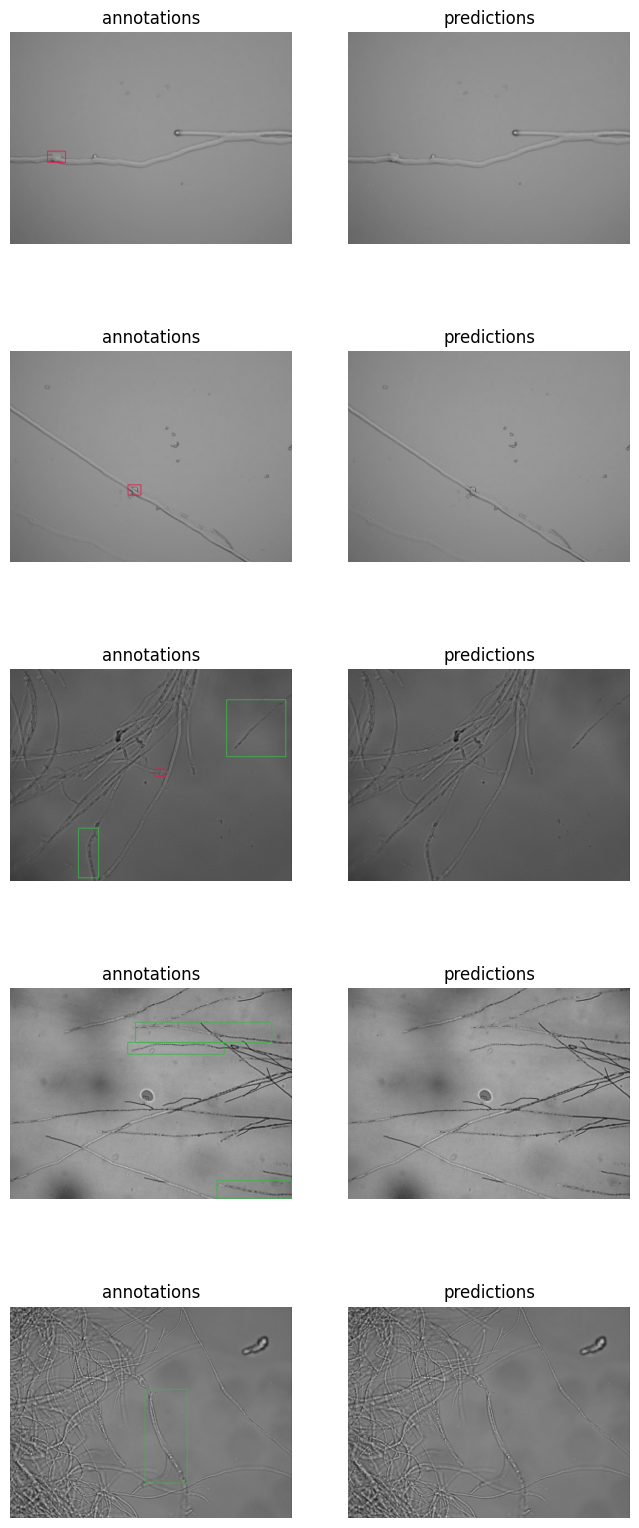

In [37]:
import supervision as sv

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

### Calculate confusion matrix

In [40]:
!pip install onemetric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.3 MB/s eta 0:00:00


In [39]:
 import locale
 locale.getpreferredencoding = lambda: "UTF-8"

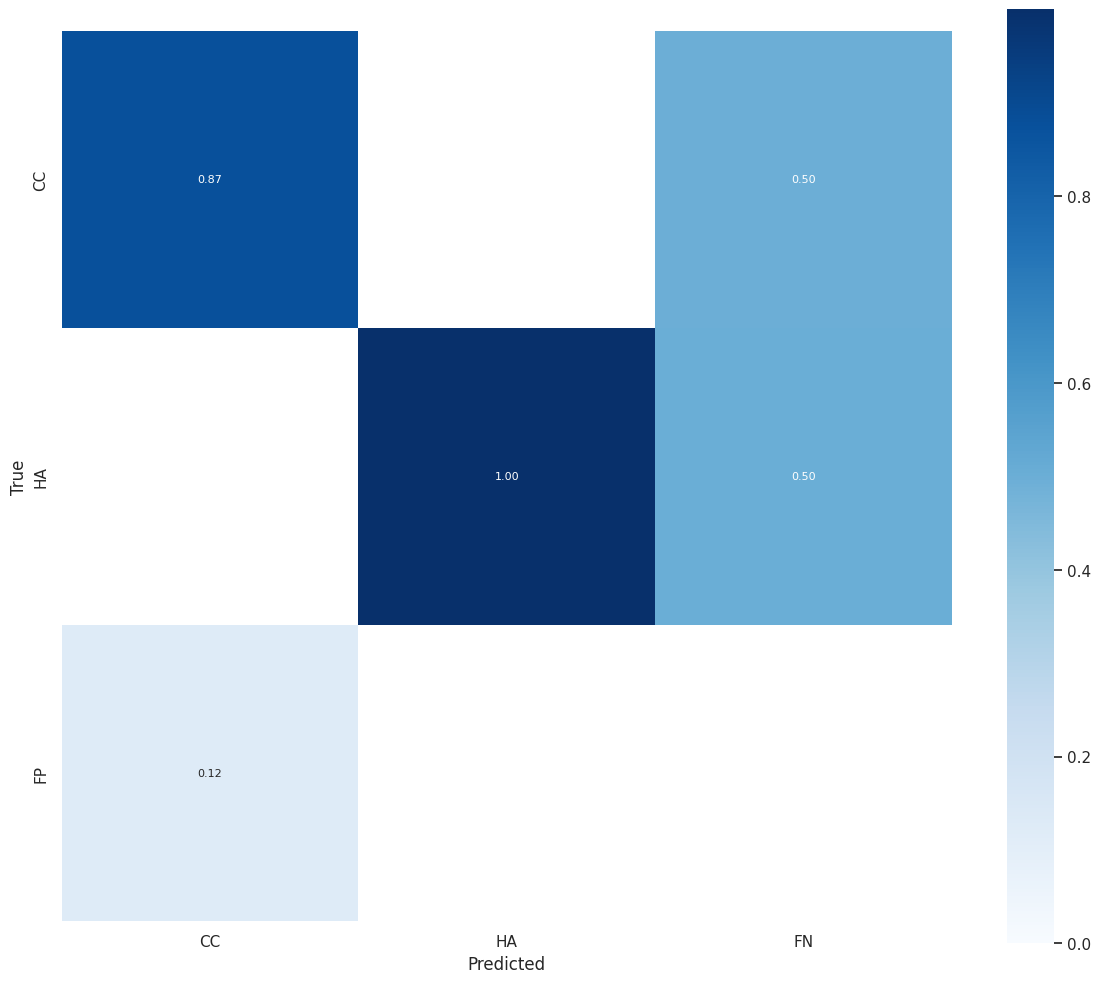

In [41]:
import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=ds.classes)

  # 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.